# **Meerkat Call Classifier**

This code takes in examples of calls of different types, trains a conv net model to detect which type, then can run this on new data.

In [157]:
#from Jake

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import GlobalAveragePooling2D, Dense

#params
batch_size=100
clips_dir  = '/home/arianasp/meerkat_detector/clips'
call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth']
verbose = True
model_dir = '/home/arianasp/meerkat_detector/models'
model_name = 'test_classifier.h5'
epochs = 10
steps_per_epoch = 1000

#MAIN

inputs = Input(shape=(None, None,1))
x = inputs
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)

# this converts feature maps to 1D feature vectors by taking the channelwise average
# Also see GlobalMaxPooling2D and Flatten layers, which also transform to 1D vectors
# GlobalAveragePooling2D has some nice properties in terms of model regularization,
# which typically makes it the best choice for this transformation
x = GlobalAveragePooling2D()(x)  
x = Dense(64, activation='relu')(x)

N_CLASSES = 10
class_probabilites = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=class_probabilites)


# use categorical_crossentropy loss if your training data are one-hot encoded vectors
# and use sparse_categorical_crossentropy loss if your training data
# are integers indicating the class label (Keras one-hot encodes this internally for training)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy']) # same applies for sparse_categorical_accuracy

#Funcs to generate data
def generate_sample_call(files, clips_dir, call_type = 'cc', call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth'], verbose=False):

    if(verbose):
        print('generating call noaug')
    #hard coded parameters for now
    samprate=8000
    pad_len = 127

    #get indexes to files of type call_type (or sample from all calls if call_type is None)
    if(call_type is not None):
        idxs = np.where([((call_type in s) & ('_aud' in s)) for s in files])[0]
    else:
        idxs = np.where(['_aud' in s for s in files])[0]
    idx = np.random.choice(idxs)

    #get audio file and mask file
    aud_file = files[idx]
    mask_file = aud_file[0:(len(aud_file) - 7)] + 'mask.npy'
    
    if(verbose):
        print(aud_file)

    #read in both files
    aud = np.load(clips_dir + '/' + aud_file)
    mask = np.load(clips_dir + '/' + mask_file)

    len_call = len(aud) - samprate*2
    if(len_call < 4096):
        offset = np.random.randint(samprate - 4096 + len_call,samprate)
    else:
        offset = samprate

    _,_,spec = spy.spectrogram(aud[(offset-pad_len):(offset+4096+pad_len)],fs=samprate,nperseg=255,noverlap=247,window='hanning')
    spec_norm = np.log(spec)
    #spec_norm = spec_norm - np.min(spec_norm) / (np.max(spec_norm) - np.min(spec_norm))
    dim_spec = spec.shape[1]
    dim_wav = aud.shape[0]
    t0_wav = samprate
    tf_wav = dim_wav - samprate
    t0_spec = int(t0_wav * float(dim_spec) / dim_wav)
    tf_spec = int(tf_wav * float(dim_spec) / dim_wav)
    call_length = tf_spec - t0_spec
    pad_length = (4096 - call_length)//2
    X = np.transpose(spec_norm)
    
    #y = mask[(offset):(offset+4096)]
    #y = y.reshape((len(y),1))
    #y = skimage.measure.block_reduce(y, (8,1), np.max)
    
    #for now keep at same shape, try diff shapes later
    y = call_types.index(call_type)
    
    return X, y

def generate_batch(batch_size,clips_dir,call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth'],call_probs = None, verbose=False):
    
    #list files
    files = os.listdir(clips_dir)
    
    #create empty lists to hold spectrograms (input) and call labels (output)
    X_list = []
    y_list = []
    
    #probability of drawing each call type can be specified or if not specified is assumed to be uniform across all call types
    if(call_probs is not None):
        call_cumprobs = np.cumsum(call_probs)
    else:
        ncalls = len(call_types)
        call_cumprobs = np.arange(0,1,step=1./ncalls)+1./ncalls #equally spaced bins for drawing probabilities
        
    #generate samples
    for idx in range(batch_size):
        
        #select call type
        r = np.random.random(1)
        idx = np.where(call_cumprobs > r)[0][0]
        call_type = call_types[idx]
        X, y = generate_sample_call(files=files, clips_dir=clips_dir, call_type=call_type, call_types=call_types, verbose=verbose)
        
        #reshape for 2d conv
        X = X.reshape((X.shape[0],X.shape[1],1))
        #y = y.reshape((y.shape[0],y.shape[1],1))
        
        #append to list
        X_list.append(X)
        y_list.append(y)
    
    #convert to stack
    X = np.stack(X_list)
    y = np.stack(y_list)
    return (X, y)

#Data generators 
def data_generator(clips_dir,batch_size=10,call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth'],call_probs = [1./7,1./7,1./7,1./7,1./7,1./7,1./7,0,0,0],verbose=False):
    while True:
        yield generate_batch(batch_size,clips_dir,call_types,call_probs,verbose=verbose)

        
#fit model
model.fit_generator(data_generator(clips_dir = clips_dir,batch_size = batch_size), epochs=epochs, use_multiprocessing=True, workers=16, steps_per_epoch=steps_per_epoch)

#Save fitted model
print('Saving model as: ' + model_name)
model.save(filepath=model_dir + '/' + model_name) 

Epoch 1/10


/home/arianasp/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 130s 130ms/step - loss: 1.9328 - sparse_categorical_accuracy: 0.1860
Epoch 2/10
1000/1000 [==============================] - 128s 128ms/step - loss: 1.8175 - sparse_categorical_accuracy: 0.2475
Epoch 3/10
1000/1000 [==============================] - 128s 128ms/step - loss: 1.3400 - sparse_categorical_accuracy: 0.4909
Epoch 4/10
1000/1000 [==============================] - 129s 129ms/step - loss: 1.1517 - sparse_categorical_accuracy: 0.5788
Epoch 5/10
1000/1000 [==============================] - 129s 129ms/step - loss: 1.0382 - sparse_categorical_accuracy: 0.6218
Epoch 6/10
1000/1000 [==============================] - 128s 128ms/step - loss: 0.9274 - sparse_categorical_accuracy: 0.6793
Epoch 7/10
1000/1000 [==============================] - 128s 128ms/step - loss: 0.8372 - sparse_categorical_accuracy: 0.7144
Epoch 8/10
1000/1000 [==============================] - 129s 129ms/step - loss: 0.7745 - sparse_categorical_accuracy: 0.7336
Epoch 9/10


[1]
sn


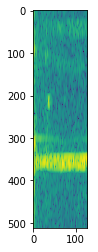

In [144]:
import os
import numpy as np
import scipy.signal as spy
import matplotlib.pyplot as plt
files = os.listdir(clips_dir)
X ,y = generate_sample_call(files,clips_dir,call_type='mov')
#plt.imshow(X,aspect='auto')
X, y = generate_batch(1,clips_dir,call_probs=[0.5,0.5,0,0,0,0,0,0,0,0])
plt.imshow(X[0,:,:,0])
print(y)
print(call_types[y[0]])

cc
cc


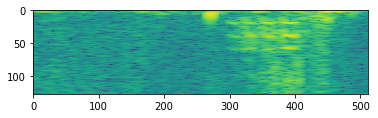

In [187]:
X,y = generate_batch(clips_dir=clips_dir,batch_size=1,call_probs=[0.5,0.5,0,0,0,0,0,0,0,0])
plt.imshow(X[0,:,:,0].T)
print(call_types[y[0]])

out= model.predict(X)
print(call_types[np.argmax(out[0])])

In [176]:
print(range(ncalls))

range(0, 10)
